In this colab, we will implement **multiclass MNIST digit recognition classifier** with **decision trees** and **ensemble techniques**.

**Import basic libraries**

In [ ]:
# plotting utility
import matplotlib.pyplot as plt

# dataset loading through mnist.
from keras.datasets import mnist

# training three classifiers: decision tree, bagging and random forest.
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# model selection utilities for training and test split and cross validation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

# use shuffle-split cross validation for this exercise.
from sklearn.model_selection import ShuffleSplit

# make use of confusion matrix and classification report to evaluate performance
# on the test set.
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# the model is defined through pipeline utility.
from sklearn.pipeline import Pipeline

## Loading MNIST dataset

We begin by loading MNIST dataset with `load_data` function in `mnist` class.

We obtain:
* Training feature matrix and labels
* Test feature matrix and labels

In [ ]:
# Load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

As you know there are 60000 examples in training set and 10000 examples in the test set.

Each example is a grey scale image of size 28x28.  There are 10 different labels - one for each digit - 0 to 9.

In [ ]:
print('Shape of training data',X_train.shape)
print('Shape of training labels', y_train.shape)
print('Shape of testing data', X_test.shape)
print('Shape of testing labels',y_test.shape)

Shape of training data (60000, 28, 28)
Shape of training labels (60000,)
Shape of testing data (10000, 28, 28)
Shape of testing labels (10000,)


Before using the dataset for training and evaluation, we need to flatten it into a vector.  After flattening, we have training and test examples represented with a vector of 784 features. Each feature records pixel intensity in each of 28x28 pixel.

We normalize the pixel intensity by dividing it with the maximum value i.e. 255.  In that sense we have each feature value in the range 0 to 1.

In [ ]:
# Flatten each input image into a vector of length 784
X_train = X_train.reshape(X_train.shape[0], 28*28)
X_test = X_test.reshape(X_test.shape[0], 28*28)

# Normalizing.
X_train = X_train/255
X_test = X_test/255

In [ ]:
print('Shape of training data after flattening',X_train.shape)
print('Shape of testing data after flattening', X_test.shape)

Shape of training data after flattening (60000, 784)
Shape of testing data after flattening (10000, 784)


We use `ShuffleSplit` cross validation with 10 splits and 20% data set aside for model evaluation as a test data.

In [ ]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

We define two functions:
1. `train_classifiers` contains a common code for training classifiers for MNIST multiclass classification problem.
  * It takes `estimator`, feature matrix, labels, cross validation strategy and name of the classifier as input.
  * It first fits the estimator with feature matrix and labels.
  * It obtains cross validated `f1_macro` score for training set with 10-fold `ShuffleSplit` cross validation and prints it.

In [ ]:
def train_classifiers(estimator, X_train, y_train, cv, name):
  estimator.fit(X_train, y_train)
  cv_train_score = cross_val_score(estimator, X_train, y_train,
                                   cv=cv, scoring='f1_macro')
  print(f"On an average, {name} model has f1 score of "
        f"{cv_train_score.mean():.3f} +/- {cv_train_score.std():.3f} on the training set.")

2. The `eval` function takes estimator, test feature matrix and labels as input and produce classification report and confuction matrix.
  * It first predicts labels for the test set.
  * Then it uses these predicted reports for calculating various evaluation metrics like precision, recall, f1 score and accuracy for each of the 10 classes.
  * It also obtains a confusion matrix by comparing these predictions with the actual labels and displays it with `ConfusionMatrixDisplay` utility.

In [ ]:
def eval(estimator, X_test, y_test):
  y_pred = estimator.predict(X_test)

  print("# Classification report")
  print(classification_report(y_test, y_pred))

  print("# Confusion matrix")
  disp = ConfusionMatrixDisplay(
      confusion_matrix=confusion_matrix(y_test, y_pred))
  disp.plot()
  plt.title('Confusion matrix')
  plt.show()

Let's train three classifiers with default parameters.
* **Decision tree**
* **Bagging classifier** - which uses decision tree as a default classifier and trains multiple decision tree classifiers on different bags obtained through bootstrap sampling of training set.
* **Random forest classifier** - which is also a bagging technique, which trains different decision tree classifiers by randomly selecting attributes for splitting on bags of boostrap sample of training set.  

# **Decision trees for MNIST multiclass classification**

We instantiate a decision tree classifier with default parameters and train it.  The `train_classifier` function prints mean of cross validated accuracy and standard deviation of the trained classifier on the training set.

In [ ]:
decision_tree_pipeline = Pipeline([("classifier", DecisionTreeClassifier())])
train_classifiers(decision_tree_pipeline, X_train, y_train.ravel(), cv,
                  "decision tree")

On an average, decision tree model has f1 score of 0.867 +/- 0.005 on the training set.


Let's evaluate the trained classifier on the test set.

# Classification report
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       980
           1       0.96      0.96      0.96      1135
           2       0.86      0.86      0.86      1032
           3       0.83      0.86      0.84      1010
           4       0.86      0.87      0.87       982
           5       0.85      0.83      0.84       892
           6       0.89      0.88      0.88       958
           7       0.91      0.90      0.91      1028
           8       0.82      0.82      0.82       974
           9       0.85      0.85      0.85      1009

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

# Confusion matrix


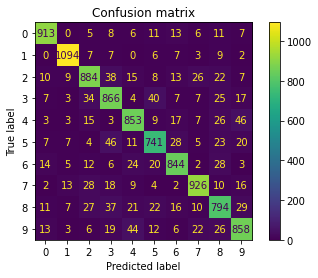

In [ ]:
eval(decision_tree_pipeline, X_test, y_test)

# **MNIST classification with Bagging**

Let's instantiate a bagging classifier object with default parameters and train it.  

Observe the mean `f1_score` and its standard deviation obtained by the classifier based 10-fold cross validation of the training set.

In [ ]:
# bagging_pipeline = Pipeline([('scaler', MinMaxScaler()),
#                                    ("classifier", BaggingClassifier())])
bagging_pipeline = Pipeline([("classifier", BaggingClassifier())])
train_classifiers(bagging_pipeline, X_train, y_train.ravel(), cv,
                  "bagging")

On an average, bagging model has f1 score of 0.937 +/- 0.005 on the training set.


Let's evaluate the trained classifier on the test set.

# Classification report
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       980
           1       0.97      0.99      0.98      1135
           2       0.92      0.93      0.93      1032
           3       0.92      0.92      0.92      1010
           4       0.94      0.94      0.94       982
           5       0.93      0.91      0.92       892
           6       0.95      0.95      0.95       958
           7       0.96      0.93      0.95      1028
           8       0.93      0.90      0.91       974
           9       0.94      0.92      0.93      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

# Confusion matrix


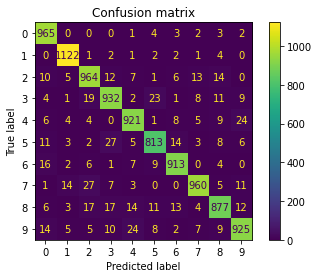

In [ ]:
eval(bagging_pipeline, X_test, y_test)

# **Random forest for MNIST multiclass classification**

Let's instantiate a random forest classifier object with default parameters and train it.  

Observe the mean `f1_score` and its standard deviation obtained by the classifier based 10-fold cross validation of the training set.

In [ ]:
# random_forest_pipeline = Pipeline([('scaler', MinMaxScaler()),
#                                    ("classifier", RandomForestClassifier())])
random_forest_pipeline = Pipeline([("classifier", RandomForestClassifier())])
train_classifiers(random_forest_pipeline, X_train, y_train.ravel(), cv,
                  "random forest")

On an average, random forest model has f1 score of 0.967 +/- 0.001 on the training set.


Let's evaluate a random forest classifier on the test set and obtain classification report containing predicision, recall, f1-score and accuracy for each class.  It also calculates confusion matrix and displays it with `ConfusionMatrixDisplay` utility.  

# Classification report
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.97      0.97      1032
           3       0.96      0.96      0.96      1010
           4       0.97      0.98      0.98       982
           5       0.97      0.96      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.96      0.97      1028
           8       0.96      0.96      0.96       974
           9       0.96      0.95      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

# Confusion matrix


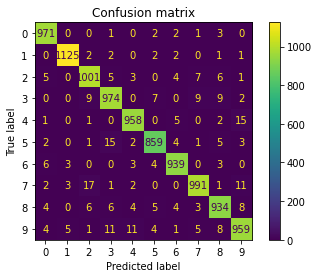

In [ ]:
eval(random_forest_pipeline, X_test, y_test)

# Summary

* We trained three multi-class classifiers for handwritten digit recognition.

* The decision tree classifier is a baseline classifier, which obtained accuracy of 88% on the test set.  

* Using bagging and training the same decision tree classifier gave us an increase of 6 percentage point in the accuracy, which translates to 94% accuracy on the test set.

* Finally random forest pushed that further to 97%.

* We can see that how ensemble techniques give better results on the classification task compared to a single classifier.

* With this demonstration, you have added three more powerful tools in your ML toolkit.